In [1]:
"""
This script will split the data into train, validation and test folders.
Script Author: Md Abid Hasan
Project: Indicate_FH
Date: 12 July 2023
"""

import splitfolders
from matplotlib import pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np  
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator
from models import my_model
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras.regularizers import l2
from split_data import *
import logging
logging.getLogger('tensorflow').disabled = True
from Image_generator import *
from clear_folder import clear_folder
"""
**Defien the network parameters which should be later in save results functions.** 
"""
#*************************************************************************************************
#Define the parameters
seed =42
SIZE = 256
batch_size = 32
verbose = 1
epochs = 100
modelname = "2DCNN"
filter_size = 64
dropout_rt = 0.4
verbose = 1
train_data_ratio=0.6
val_data_ratio = 0.2
test_data_ratio = 0.2
percentage_to_read = 30

#**********************************************************************************************************************
#Declare the path
datapath = '/home/abidhasan/Documents/Indicate_FH/data'
figpath = '/home/abidhasan/Documents/Indicate_FH/performance_figures'
modelpath = '/home/abidhasan/Documents/Indicate_FH/saved_model'
checkpointpath = '/home/abidhasan/Documents/Indicate_FH/checkpoints'
# Specify the folder path you want to save the augmented images
effected_aug_data_folder = '/home/abidhasan/Documents/Indicate_FH/aug_image/effected'
not_effected_aug_data_folder = '/home/abidhasan/Documents/Indicate_FH/aug_image/not_effected'
# Specify the folder path you want to read the images from
effected_image_directory = '/home/abidhasan/Documents/Indicate_FH/data/effected'
not_effected_image_directory = '/home/abidhasan/Documents/Indicate_FH/data/not_effected'


#*********************************************************************************************************************
val = input('Do you want to augmented the data? yes or no: ')
if val.lower() == 'yes':
    image_generator(SIZE, batch_size, percentage_to_read,  effected_aug_data_folder, not_effected_aug_data_folder, effected_image_directory, not_effected_image_directory)
elif val.lower() == 'no':
    print('You did nt use the Augmentation data')
else:
    print('you did not choose yes or no')
    
#*********************************************************************************************************************
# This code will copy all the Augmented images into the train dataset. 

import shutil

def copy_images(source_directory, destination_directory):
    # Check if the source directory exists
    if not os.path.exists(source_directory):
        print(f"Source directory '{source_directory}' does not exist.")
        return
    
    # Check if the destination directory exists, create it if not
    if not os.path.exists(destination_directory):
        os.makedirs(destination_directory)
    
    # Loop through files in the source directory
    for filename in os.listdir(source_directory):
        source_file = os.path.join(source_directory, filename)
        
        if filename.endswith(('.jpg', '.jpeg', '.png', '.gif')):  # Add more image formats as needed
            destination_file = os.path.join(destination_directory, filename)
            shutil.copy(source_file, destination_file)
            print(f"Copied '{filename}' to '{destination_directory}'")

# Source and destination directory paths
#***********__________Split the Dataset into Train, Validation and test folders________ ********

split = input("Split the dataset into train, test and validation: ")
if split.lower() == 'yes':
    clear_folder('/home/abidhasan/Documents/Indicate_FH/train_val_test')
    split_data(datapath, train_data_ratio, val_data_ratio, test_data_ratio)
    combine = input("Do you want to combine the augmented data into trainset? (yes/no): ")
    if combine.lower() == 'yes': 
        copy_images(effected_aug_data_folder, '/home/abidhasan/Documents/Indicate_FH/train_val_test/train/effected')
        copy_images(not_effected_aug_data_folder, '/home/abidhasan/Documents/Indicate_FH/train_val_test/train/not_effected')
    else:
        print('Augmented data is not used in training set\n')
        
elif split.lower() == 'no':
    print('You did not split the dataset')
else:
    print('You did not choose yes or no')

#**********************************************************************************************
# This code will copy all the Augmented images into the train dataset. 

import shutil

def copy_images(source_directory, destination_directory):
    # Check if the source directory exists
    if not os.path.exists(source_directory):
        print(f"Source directory '{source_directory}' does not exist.")
        return
    
    # Check if the destination directory exists, create it if not
    if not os.path.exists(destination_directory):
        os.makedirs(destination_directory)
    
    # Loop through files in the source directory
    for filename in os.listdir(source_directory):
        source_file = os.path.join(source_directory, filename)
        
        if filename.endswith(('.jpg', '.jpeg', '.png', '.gif')):  # Add more image formats as needed
            destination_file = os.path.join(destination_directory, filename)
            shutil.copy(source_file, destination_file)
            print(f"Copied '{filename}' to '{destination_directory}'")


#**********************************************************************************************


# example of progressively loading images from file
# create generator


datagen = ImageDataGenerator(rescale=1./255)

# prepare an iterators for each dataset

# load and iterate training dataset
#If I want to resize the Image then put the following param to flow_from_directory
target_size = (SIZE, SIZE)
train_it = datagen.flow_from_directory('/home/abidhasan/Documents/Indicate_FH/train_val_test/train/', seed=seed, class_mode='binary', target_size=target_size, batch_size=batch_size)
# load and iterate validation dataset
val_it = datagen.flow_from_directory('/home/abidhasan/Documents/Indicate_FH/train_val_test/val/', class_mode='binary', target_size=target_size, batch_size=batch_size)
# load and iterate test dataset
test_it = datagen.flow_from_directory('/home/abidhasan/Documents/Indicate_FH/train_val_test/test/', class_mode='binary', target_size=target_size, batch_size=batch_size)
# load and iterate test dataset for the prediction perpose when the batch_size==1, as we want to predict each image.
predict_it = datagen.flow_from_directory('/home/abidhasan/Documents/Indicate_FH/train_val_test/test/', class_mode='binary', target_size=target_size, batch_size=1)

# confirm the iterator works
train_X, train_y = train_it.next()
print('Train Batch shape=%s, min=%f, max=%f' % (train_X.shape, train_X.min(), train_X.max()))
print('shape of labels=%s' % (train_y.shape))
print(np.unique(train_y, return_counts=True))

# confirm the iterator works
test_X, test_y = test_it.next()
print('Test Batch shape=%s, min=%f, max=%f' % (test_X.shape, test_X.min(), test_X.max()))
print('shape of labels=%s' % (test_y.shape))
print(np.unique(test_y, return_counts=True))



# Defining the input shape 
img_height = train_X.shape[1]
img_width = train_X.shape[2]
img_channels = train_X.shape[3]
INPUT_SHAPE = (img_height, img_width, img_channels)

# Checking the input parameters
train_filenames = train_it.filenames
num_train_img = len(train_filenames)
valid_filenames = val_it.filenames
num_valid_img = len(val_it.filenames)
test_filenames = test_it.filenames
num_test_img = len(test_filenames)
print('num_train_img', num_train_img)
print('num_valid_img', num_valid_img)
print('num_test_img', num_test_img)

train_steps_per_epoch = num_train_img//batch_size
val_steps_per_epoch = num_valid_img//batch_size #******* Here Considering valid image is Validation image *******
test_steps_per_epoch = num_test_img//batch_size
print("Train Steps per epoch=", train_steps_per_epoch)
print("Test Steps per epoch=", test_steps_per_epoch)
print("val Steps per epoch=", val_steps_per_epoch)


#Predecting the test imageset results
predict_filenames = predict_it.filenames
# Then set the steps of predict_generator to the total number of your test images
num_predict_img = len(predict_filenames)
predict_steps_per_epoch = num_predict_img//1
print("Predict steps per Epoch:", predict_steps_per_epoch)



#ModelCheckpoint callback saves a model at some interval. 
checckpoint_filepath= checkpointpath + '/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5' #File name includes epoch and validation accuracy.
#Use Mode = max for accuracy and min for loss. 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint(checckpoint_filepath, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
#CSVLogger logs epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger(checkpointpath+'/my_logs.csv', separator=',', append=False)
callbacks_list = [mc, es, log_csv]
 

You did nt use the Augmentation data
You did not split the dataset
Found 15736 images belonging to 2 classes.
Found 1782 images belonging to 2 classes.
Found 1783 images belonging to 2 classes.
Found 1783 images belonging to 2 classes.
Train Batch shape=(32, 256, 256, 3), min=0.000000, max=1.000000
shape of labels=32
(array([0., 1.], dtype=float32), array([15, 17]))
Test Batch shape=(32, 256, 256, 3), min=0.000000, max=1.000000
shape of labels=32
(array([0., 1.], dtype=float32), array([ 6, 26]))
num_train_img 15736
num_valid_img 1782
num_test_img 1783
Train Steps per epoch= 491
Test Steps per epoch= 55
val Steps per epoch= 55
Predict steps per Epoch: 1783


In [2]:

#model_name = ["my_model", "vgg_1", "vgg_2", "vgg_3"]
#dropout_rt =[0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

# TODO : For loop to check the all model and dropout rates are

#************************************************************************************************
# Generating the model from Models script   
model = my_model(filter_size, INPUT_SHAPE, dropout_rt)
model.summary()
history =  model.fit(train_it, steps_per_epoch=train_steps_per_epoch, validation_data=val_it, validation_steps=val_steps_per_epoch, epochs=epochs, verbose = verbose, callbacks = callbacks_list)
scores= model.evaluate(test_it, steps=test_steps_per_epoch)
print(f'Score for test Image: {model.metrics_names[0]} = {scores[0]}; {model.metrics_names[1]} = {scores[1] * 100}%')
model.save(modelpath+'/2DCNN_BASE_WITH_AUG.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 127, 127, 64)     256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 127, 127, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0

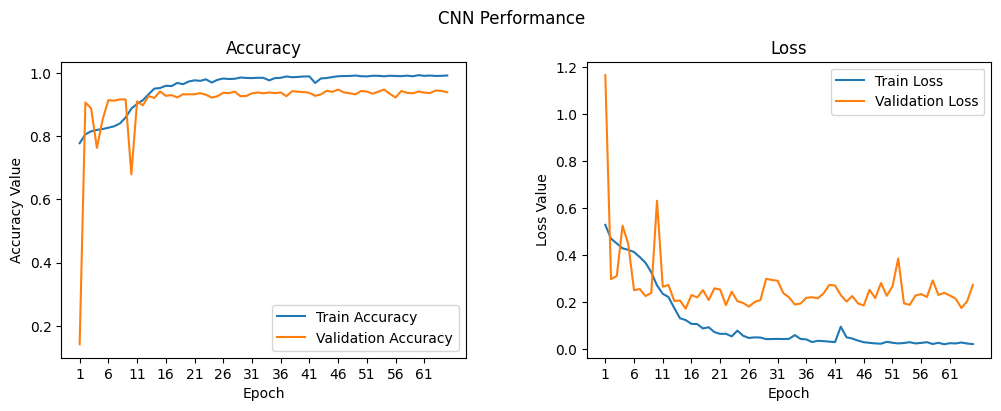

<Figure size 640x480 with 0 Axes>

In [3]:
#*************************************************************************************************
#Plotting the Train and Validation accuracy and loss.

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1, max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")
plt.show()
plt.savefig(figpath+'/CNN_TRAIN_VS_VALIDATION_LOSS_WITH_AUG.png', bbox_inches='tight')

In [4]:
#Load the saved model
from keras.models import load_model
model = load_model(modelpath+'/2DCNN_BASE_MODEL.h5')

1783/1783 [==============================] - 6s 4ms/step


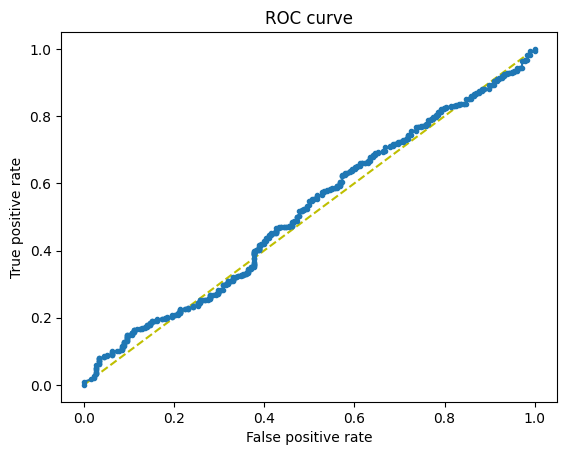

In [5]:
#************************************************************************************************
#Plotting the ROC and AUC from the evaluated model
#ROC
from sklearn.metrics import roc_curve
y_preds = model.predict(predict_it, steps=predict_steps_per_epoch).ravel()
y_test = test_it.classes

fpr, tpr, thresholds = roc_curve(y_test, y_preds)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.savefig(figpath+'/ROC_CURVE_WITH_AUG.png', bbox_inches='tight')
plt.show()

In [6]:
"""
#One way to find the best threshold once we calculate the true positive 
and false positive rates is ...
The optimal cut off point would be where “true positive rate” is high 
and the “false positive rate” is low. 
Based on this logic let us find the threshold where tpr-(1-fpr) is zero (or close to 0)
"""
import pandas as pd
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 
optimal_cutoff = ideal_roc_thresh['thresholds'].values
#Now use this threshold value in the confusion matrix to visualize the balance
#between tp, fp, fp, and fn

Ideal threshold is:  302    0.999684
Name: thresholds, dtype: float32


In [7]:
#AUC
#Area under the curve (AUC) for ROC plot can be used to understand hpw well a classifier 
#is performing. 
#% chance that the model can distinguish between positive and negative classes.

from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)

Area under curve, AUC =  0.515172039623368


1783/1783 [==============================] - 6s 3ms/step
Printing the Predicted class details:
 (array([0, 1]), array([ 237, 1546]))
Printing the True class details:
 (array([0, 1], dtype=int32), array([ 178, 1605]))
Classification report
               precision    recall  f1-score   support

    effected       0.09      0.12      0.11       178
not_effected       0.90      0.87      0.88      1605

    accuracy                           0.79      1783
   macro avg       0.50      0.49      0.49      1783
weighted avg       0.82      0.79      0.80      1783

Confusion Matrix
 [[  22  156]
 [ 215 1390]]
Average F1 Score per class: [0.1060241 0.8822596]
Average_Macro F1 Score of the Model: 0.4941418482562431
Average_Weighted F1 score of the Model: 0.8047666558386828
Accuracy of the Model: 94.20454502105713%


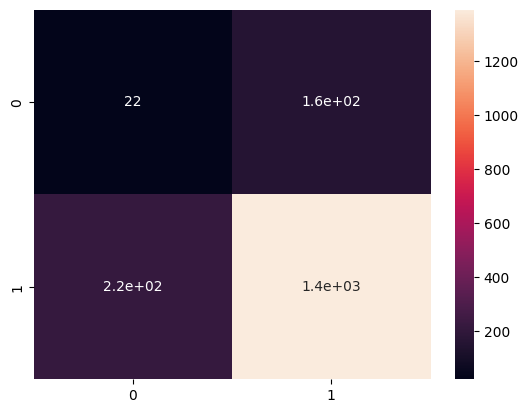

In [10]:
#************************************************************************************************
#Printing the confusion matrix, F1 score and accuracy on test dataset.

# model = tf.keras.models.load_model(saved_model_dir + 'baseline_model_load_from_disk.hdf5', compile=False)

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix, f1_score, classification_report
mythreshold = 0.99
predicted_class = (model.predict(predict_it, steps=predict_steps_per_epoch)>= mythreshold).astype(int)
print('Printing the Predicted class details:\n', np.unique(predicted_class, return_counts=True))
true_classes = test_it.classes
print('Printing the True class details:\n', np.unique(true_classes, return_counts=True))
class_labels = list(test_it.class_indices.keys())
report = classification_report(true_classes, predicted_class, target_names=class_labels)
print('Classification report\n', report)
cm = confusion_matrix(true_classes, predicted_class)
print('Confusion Matrix\n', cm)
import seaborn as sns
hmp = sns.heatmap(cm, annot=True)
hmp_fig = hmp.get_figure()
hmp_fig.savefig(figpath+'/heatmap_WITH_AUG.png', dpi = 400)

f1scores_per_class = (f1_score(true_classes, predicted_class, average=None))
average_fscore_macro = (f1_score(true_classes, predicted_class, average="macro"))
average_fscore_weighted = (f1_score(true_classes, predicted_class, average="weighted"))
print('Average F1 Score per class:', f1scores_per_class)
print('Average_Macro F1 Score of the Model:', average_fscore_macro)
print('Average_Weighted F1 score of the Model:', average_fscore_weighted)
print(f'Test Accuracy of the Model: {scores[1] * 100}%')